In [1]:

import pandas as pd
import numpy as np
import pyaf.ForecastEngine as autof
import pyaf.Bench.TS_datasets as tsds
#import SignalDecomposition_Perf as tsperf


%matplotlib inline  

In [2]:
import datetime


def convert_double_to_datetime(x):
    ratio = (x - int(x))
    fulldate = datetime.datetime(int(x), 1, 1, 0, 0, 0)
    year_length = datetime.datetime(int(x) + 1, 1, 1, 0, 0, 0) - fulldate
    fulldate = fulldate + datetime.timedelta(days = int(year_length.days*ratio))
    return fulldate


In [3]:
# examples using the autoforecast public API on some datasets (coming from R). see the link below for more datasets.
def analyzeTimeSeriesDataset(filename, horizon):
    # filename = AirPassengers.csv
    lCSVFile = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/R_TSData/" + filename;
    # get the CSV file in a pandas datafrmae
    df = pd.read_csv(lCSVFile, sep=r',', engine='python');
    # in R_TSDAta , the date column is the first column
    lDateCol = df.columns[0];
    df[lDateCol] = df[lDateCol].apply(lambda x : convert_double_to_datetime(x))
    # length of the time series
    lLength = df.shape[0];
    # use only the N - H first rows for prediction, predict the H last and compare with actual values
    lTrainDataset = df[0:lLength - horizon];
    for col in df.columns:
        if(col != lDateCol):
            # forecast each cloumn separately in ths demo
            lSignalCol = col;
            # create a model(autoforecast object) ..... handle all the process
            lAutoF = autof.cForecastEngine()
            # set soem options
            lAutoF.mOptions.mEnableSeasonals = True;
            #lAutoF.mOptions.enable_slow_mode()
            #lAutoF.mOptions.mCycle_Criterion = "L2";
            #lAutoF.mOptions.mCycle_Criterion_Threshold = 10000.2;
            # train the model
            lAutoF.train(lTrainDataset , lDateCol , lSignalCol, horizon)
            # get some mdoel info
            lAutoF.getModelInfo();
            # access some advanced info ... for aficionados only!!!
            lAutoF.mSignalDecomposition.mBestModel.mTimeInfo.mResolution
            # define an input dataframe
            lInput = lTrainDataset.copy();
            #print(lInput.tail())
            # output dataframe ('forecast' API call ;)
            lOutput = lAutoF.forecast(lInput, horizon);
            print("Forecast Columns " , lOutput.columns);
            # Here , in the output dataframe, we keep only the data, signal and forecast outputs
            lForecastCol = lSignalCol + '_Forecast';
            lForecastDataFrame = lOutput[[lDateCol , lSignalCol, lForecastCol]]
            print(lForecastDataFrame.info())
            # actual values
            print("Actual : \n" , df[[lDateCol , lSignalCol]].tail(horizon).values);
            # predcit values
            print("Predicted : \n" , lForecastDataFrame.tail(horizon).values);

            # serialize the model as json
            print("\n\n<ModelInfo>")
            print(lAutoF.to_json());
            print("</ModelInfo>\n\n")

            # serialize the forecasts as json
            print("\n\n<Forecast>")
            print(lForecastDataFrame.tail(horizon).to_json(date_format='iso'))
            print("</Forecast>\n\n")
            
            # some plots
            lAutoF.standrdPlots()
            
            lActualAndPredictedDF = pd.DataFrame();
            lActualAndPredictedDF['Date'] = df[lDateCol];
            lActualAndPredictedDF['Signal'] = df[lSignalCol];
            lActualAndPredictedDF['Forecast'] = lForecastDataFrame[lForecastCol];
            lActualAndPredictedDF['Residue'] = lActualAndPredictedDF['Forecast'] - lActualAndPredictedDF['Signal'];
            print(lActualAndPredictedDF.tail(horizon).values)
            lActualAndPredictedDF.plot.line('Date', ['Signal', 'Forecast' , 'Residue'], figsize=(32, 16))
            
    return None;


Forecast Columns  Index(['Index', 'RelDiff_x', 'x', 'row_number', 'Index_Normalized',
       'RelDiff_x_Lag1Trend', 'RelDiff_x_Lag1Trend_residue',
       'RelDiff_x_Lag1Trend_residue_Seasonal_DayOfWeek',
       'RelDiff_x_Lag1Trend_residue_Seasonal_DayOfWeek_residue',
       'RelDiff_x_Lag1Trend_residue_Seasonal_DayOfWeek_residue_NoAR',
       'RelDiff_x_Lag1Trend_residue_Seasonal_DayOfWeek_residue_NoAR_residue',
       'RelDiff_x_Trend', 'RelDiff_x_Trend_residue', 'RelDiff_x_Cycle',
       'RelDiff_x_Cycle_residue', 'RelDiff_x_AR', 'RelDiff_x_AR_residue',
       'RelDiff_x_TransformedForecast', 'RelDiff_x_TransformedResidue',
       'x_Forecast', 'x_Residue', 'x_Forecast_Lower_Bound',
       'x_Forecast_Upper_Bound'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2820 entries, 0 to 2819
Data columns (total 3 columns):
Index         2820 non-null datetime64[ns]
x             2813 non-null float64
x_Forecast    2820 non-null float64
dtypes: datetime64[ns](1), f

/usr/lib/python3/dist-packages/matplotlib/__init__.py:1403: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


[[Timestamp('1983-06-02 00:00:00') 91.1 94.71443661895684
  3.6144366189568444]
 [Timestamp('1983-07-02 00:00:00') 82.2 90.28531856275191 8.085318562751908]
 [Timestamp('1983-08-01 00:00:00') 71.8 85.27260898272277
  13.472608982722775]
 [Timestamp('1983-09-01 00:00:00') 50.3 80.20437977365644
  29.904379773656444]
 [Timestamp('1983-10-01 00:00:00') 55.8 76.13487919589356
  20.334879195893564]
 [Timestamp('1983-11-01 00:00:00') 33.3 71.50139695695702
  38.201396956957026]
 [Timestamp('1983-12-01 00:00:00') 33.4 67.41001598031497 34.01001598031497]]


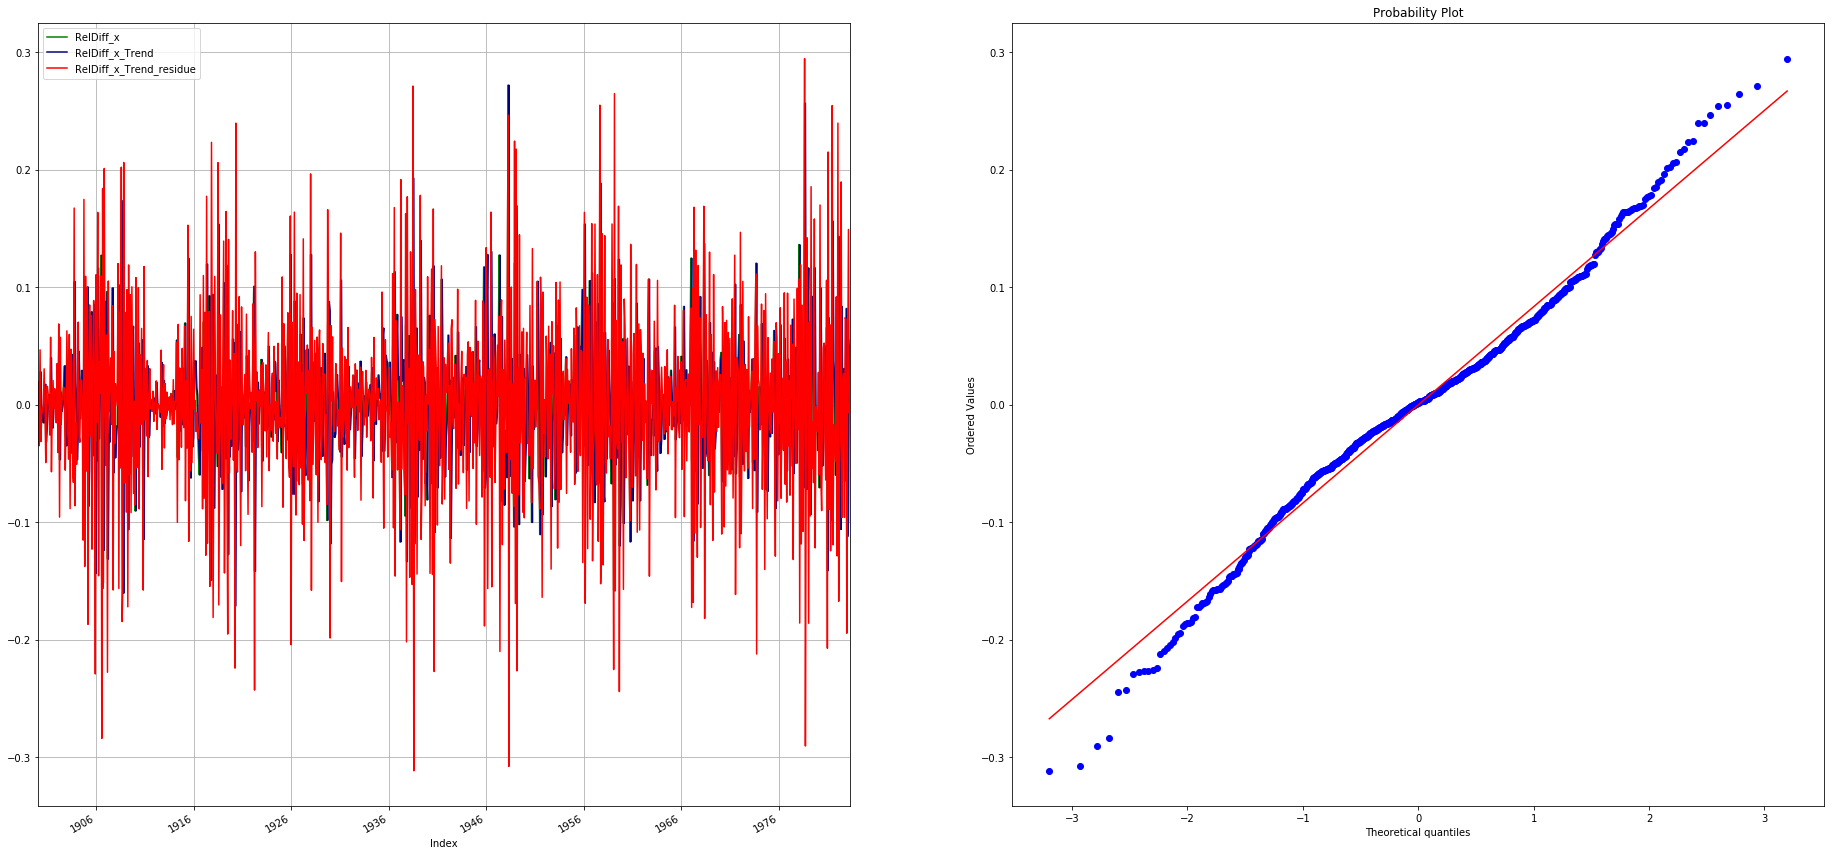

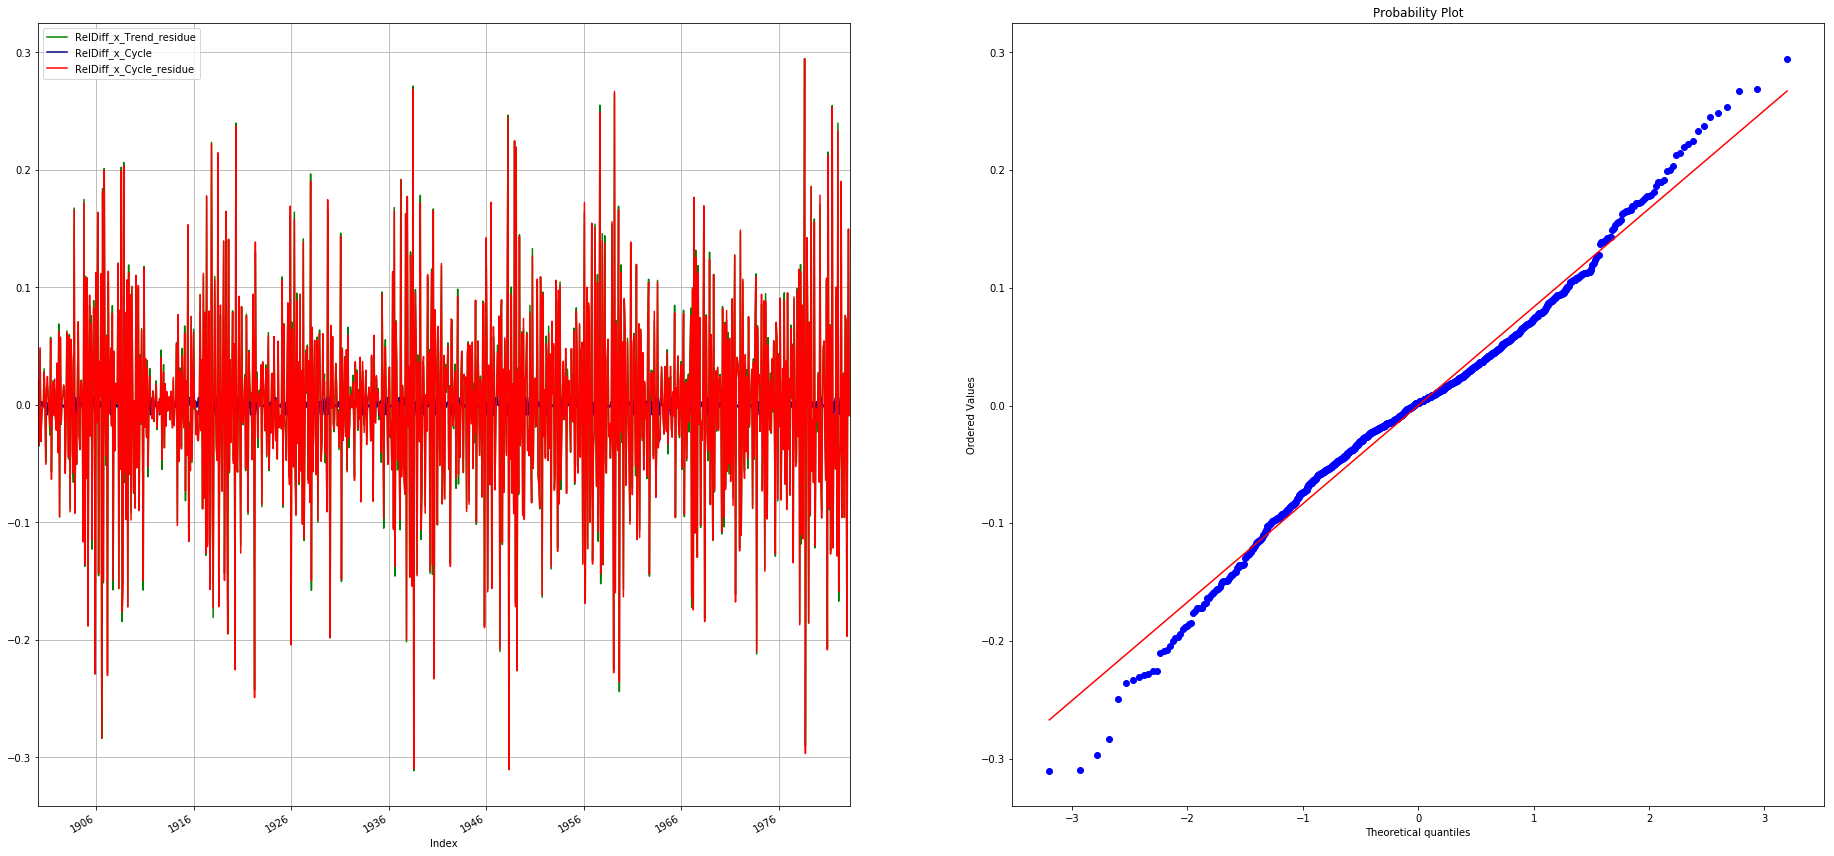

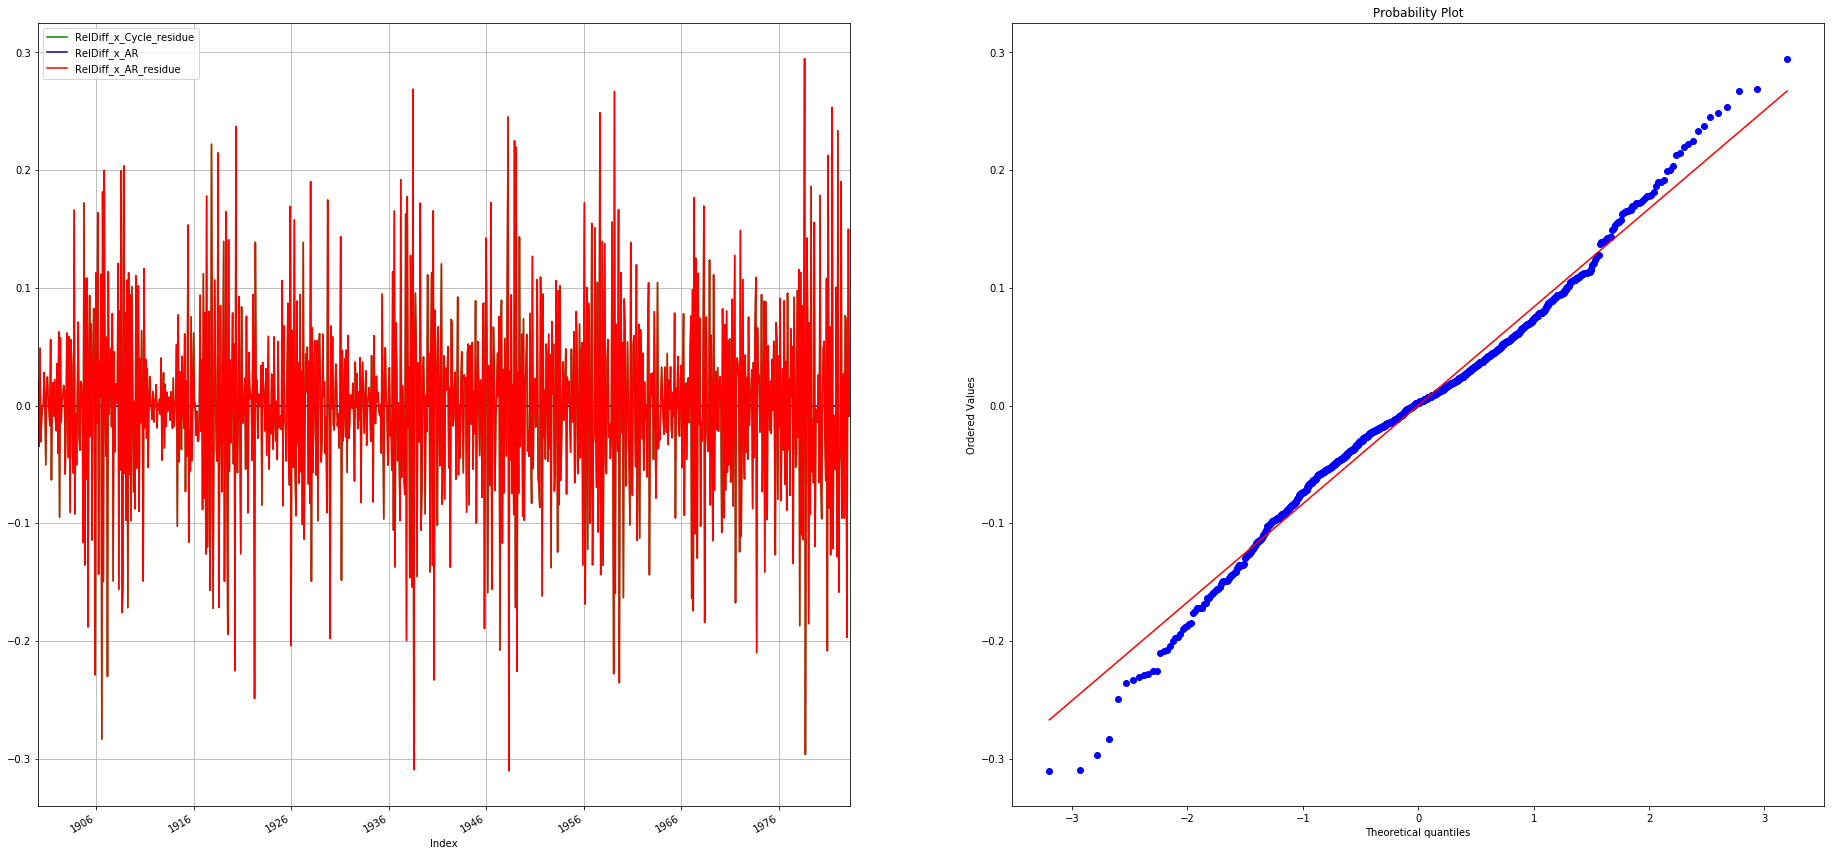

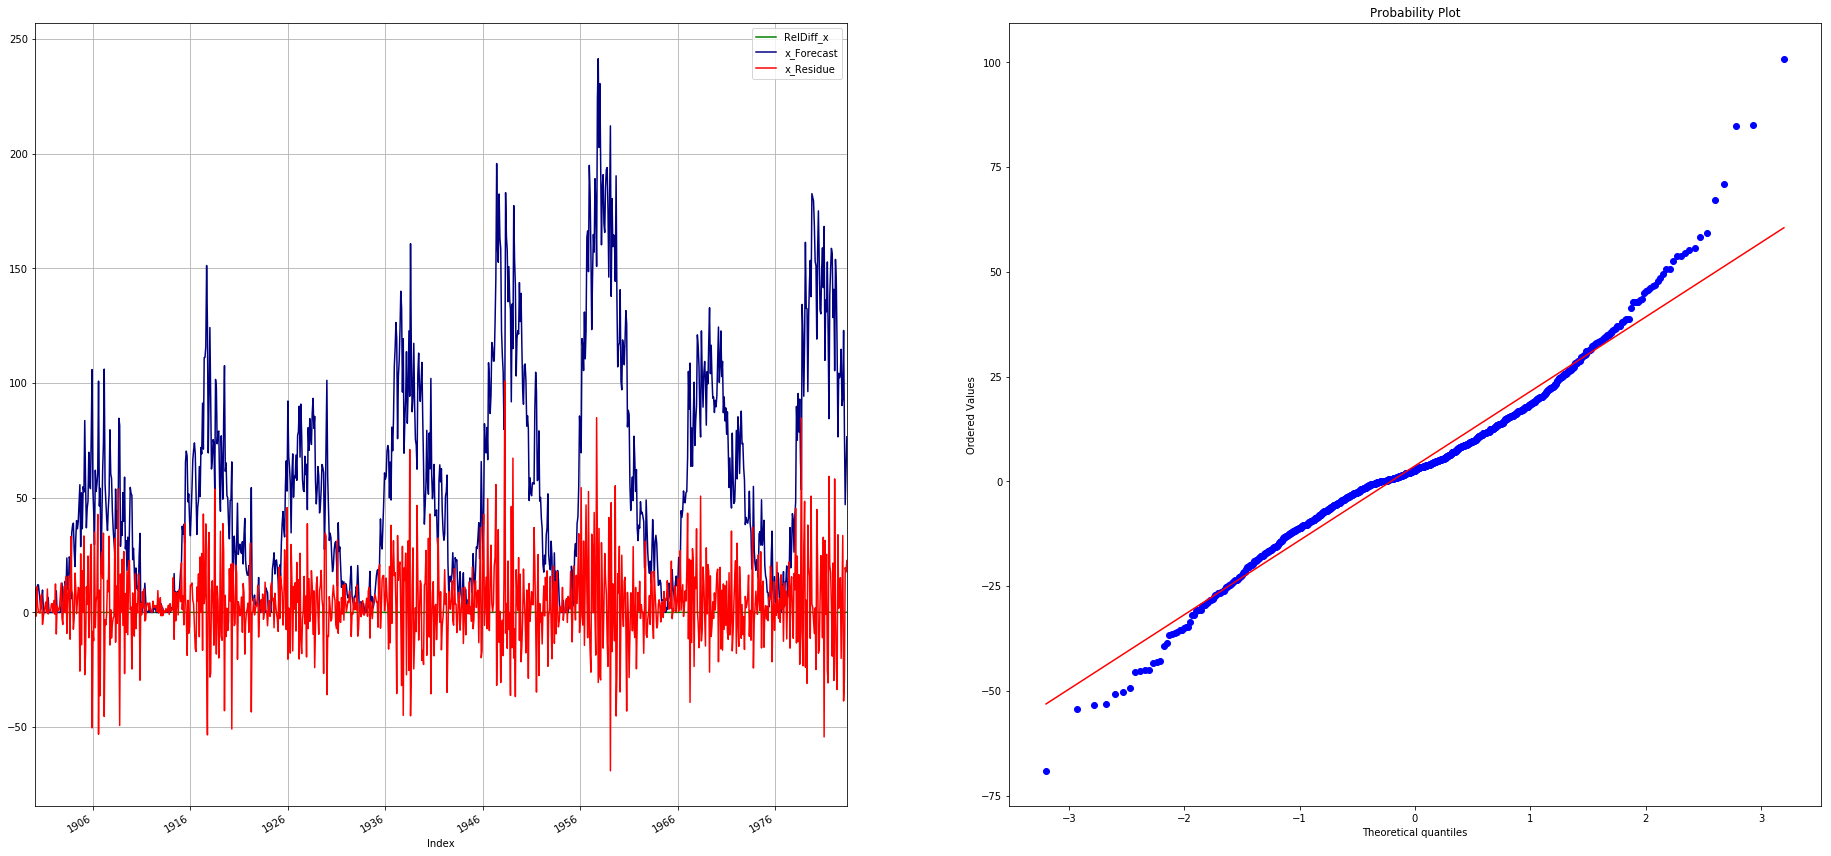

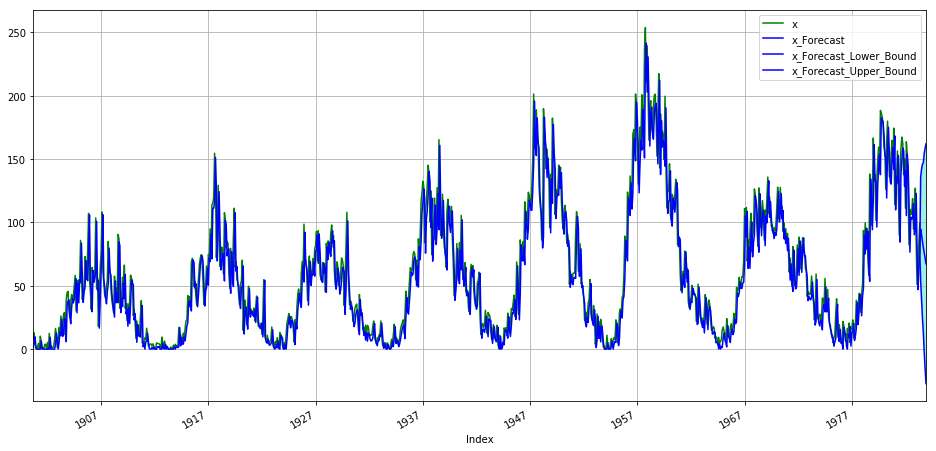

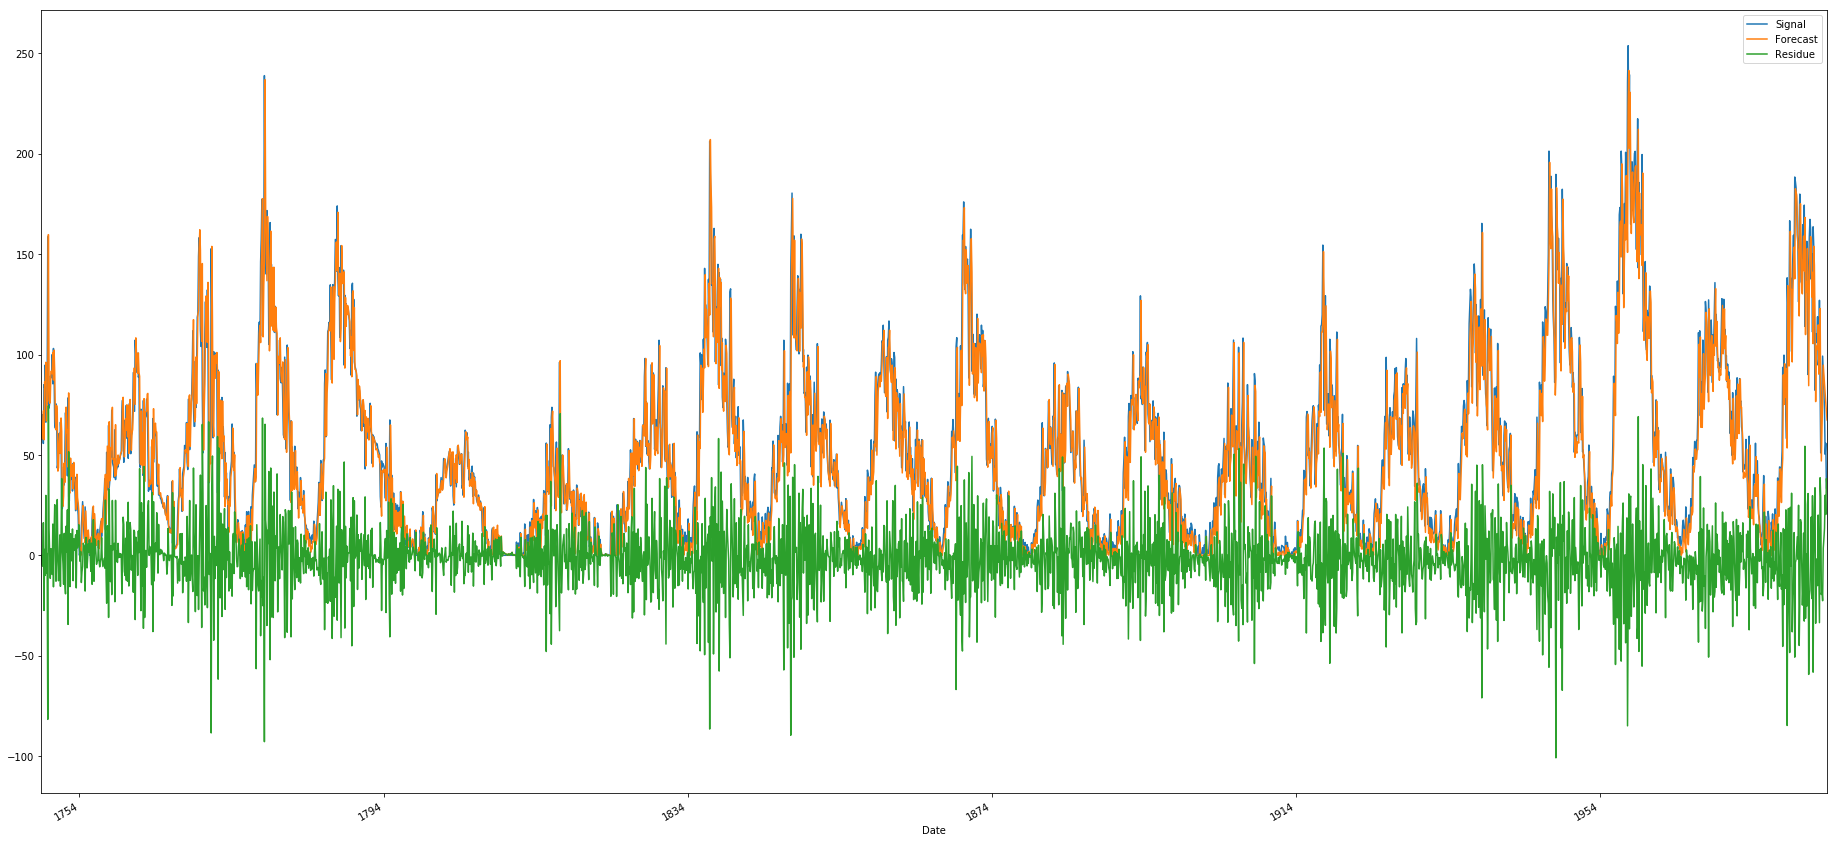

In [4]:
R_TSeries = "AirPassengers.csv austres.csv beaver1.csv beaver2.csv BJsales.csv co2.csv DM.csv EuStockMarkets.csv \
            fdeaths.csv JohnsonJohnson.csv LakeHuron.csv ldeaths.csv lh.csv lynx.csv mdeaths.csv Nile.csv nottem.csv \
            sunspot.month.csv sunspots.csv sunspot.year.csv treering.csv UKDriverDeaths.csv UKgas.csv USAccDeaths.csv \
            WWWusage.csv".split();

analyzeTimeSeriesDataset("sunspots.csv" , 7)


In [5]:
# lCSVFile = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/R_TSData/" + "AirPassengers.csv";
# df = pd.read_csv(lCSVFile, sep=r',', engine='python');
# df.info()

In [6]:
# df.Index

In [7]:

# a = df.Index.apply(lambda x : convert_double_to_datetime(x))
# a
